In [3]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [4]:
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')

In [5]:
openai = OpenAI()
model = "gpt-4o-mini"

In [6]:
system_msg = "You are a helpful assitant in a comic book store. You should try to gently encourage the \
    customer to try the books that are on sale. Indian comic books are on 60% off, and most other items \
    are 50% off. For example, if the customer says, 'I'm looking to buy panchatantra', you could reply with \
    the 'Great choice, we have 60% off on it'. Encourage customer to buy comic by getting their prefrences and \
    recommending them comics according to their taste/genre preferences"

In [7]:
def chat(message, history):
    messages = [{"role": "system", "content": system_msg}] + history + [{"role": "user", "content": message}]
    stream = openai.chat.completions.create(messages=messages, model=model, stream=True)
    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

In [8]:
gr.ChatInterface(fn=chat, type="messages").launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2025/03/07 14:33:34 [W] [service.go:132] login to server failed: i/o deadline reached


In [9]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [10]:
ticket_prices = {"mumbai": "$799", "pune": "$899", "tokyo": "$1400", "berlin": "$499"}
def get_ticket_price(dest_city):
    print(f'Tool get_ticket_price called for {dest_city}')
    return ticket_prices.get(dest_city.lower(), "Unknown")

In [11]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get  the price of a return ticket to the destination city. Call this whenever you need \
        to know the ticket price, for eg when a customer asks 'How much is the ticket to this city?'",
    "parameters":{
        "type": "object",
        "properties":{
            "dest_city":{
                "type": "string",
                "description": "The city that customer wants to travel to"
            }
        },
        "required" : ["dest_city"],
        "additional_properties" : False
    }
}

tools = [{"type":"function", "function": price_function}]

In [12]:
import json
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city =  arguments.get('dest_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"dest_city":city, "price":price}),
        "tool_call_id" : tool_call.id
    }
    return response , city

In [13]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=model, messages=messages, tools=tools)
    print(response)
    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        resp, city = handle_tool_call(message)
        messages.append(message)
        messages.append(resp)
        response = openai.chat.completions.create(model=model, messages=messages)
    return response.choices[0].message.content

In [14]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [15]:
import base64
from io import BytesIO
from PIL import Image

In [16]:
def artist(city):
    image_response = openai.images.generate(
        model="dall-e-3",
        prompt = f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size= "1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

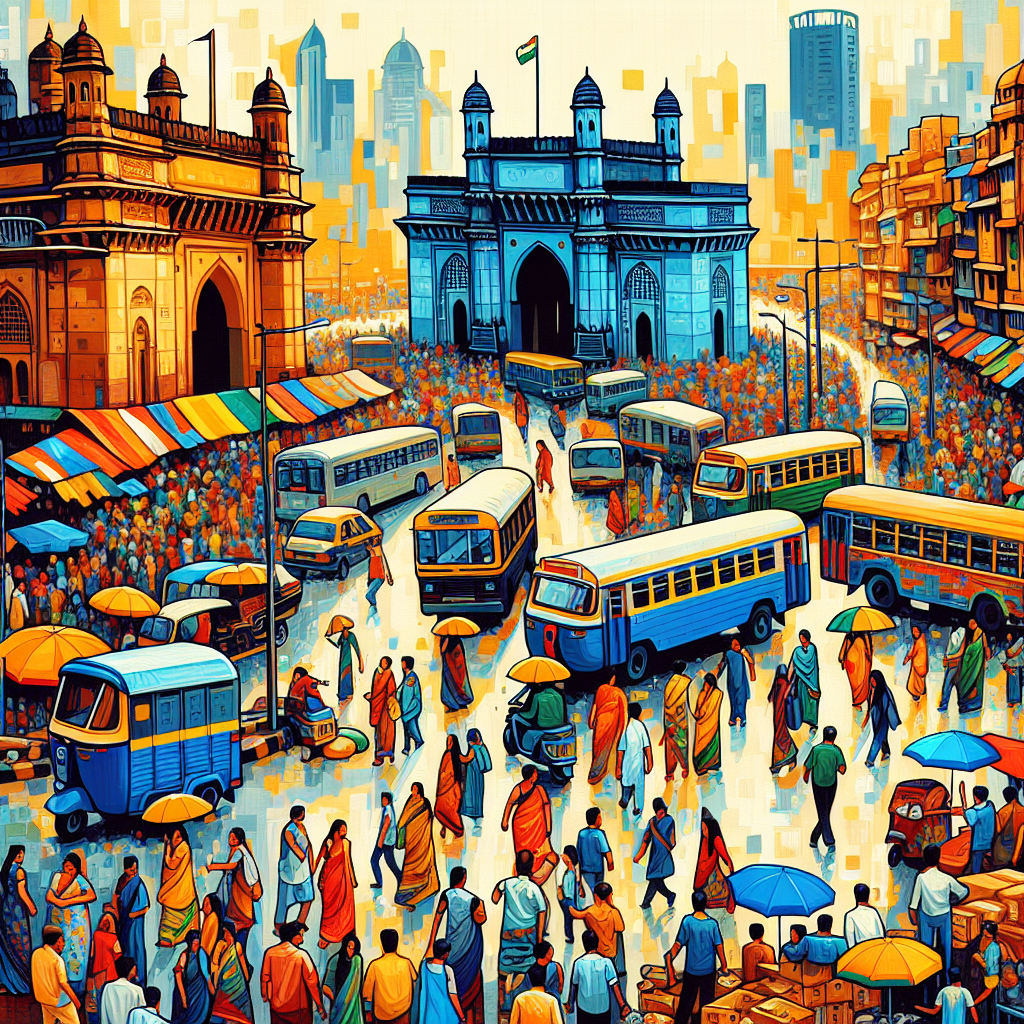

In [32]:
image = artist("Mumbai")
display(image)

In [42]:
from pydub import AudioSegment
from pydub.playback import play
import tempfile
import time, subprocess
from IPython.display import Audio, display

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(1) # Student Dominic found that this was needed. You could also try commenting out to see if not needed on your PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass

def talker(message):
    response = openai.audio.speech.create(
        model= "tts-1-hd",
        voice= "alloy",
        input= message
    )
    audio_stream = BytesIO(response.content)
    # output_filename = "output_audio.mp3"
    # with open(output_filename, "wb") as f:
    #     f.write(audio_stream.read())
    # display(Audio(output_filename, autoplay=True))
    audio = AudioSegment.from_file(audio_stream, format= "mp3")
    play_audio(audio)

In [43]:
talker("Hey! Welcome to Mumbai!!!")

In [44]:
def chat(history):
    messages = [{"role":"system", "content":system_message}] + history
    response = openai.chat.completions.create(model=model, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason == "tool_calls":
        message = response.choices[0].message
        resp, city = handle_tool_call(message)
        messages.append(message)
        messages.append(resp)
        image = artist(city)
        response = openai.chat.completions.create(model=model, messages=messages)
    
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content": reply}]

    talker(reply)
    return history, image

In [45]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type= "messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with your AI Assitant")
    with gr.Row():
        clear = gr.Button("Clear")
    
    def do_entry(message, history):
        history += [{"role":"user", "content": message}]
        return "", history
    
    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry,chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda:None , inputs=None, outputs=chatbot, queue=False)
ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Pune
